# Setup

In [263]:
# Common imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import sklearn
import numpy as np
import os
import tarfile
import urllib.request
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier

# CONSTANTS
PROJECT_ROOT_DIR = "."
VERSION = "0.0.0"
ORG_TRAIN_DATASET_PATH = os.path.join(
    PROJECT_ROOT_DIR, "datasets", "Phising_Training_Dataset.csv")
ORG_TEST_DATASET_PATH = os.path.join(
    PROJECT_ROOT_DIR, "datasets", "Phising_Testing_Dataset.csv")
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", VERSION)
Y_LABEL = "Result"
RANDOM_STATE: int = 42

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## Import Data

In [264]:
org_train_dataset = pd.read_csv(ORG_TRAIN_DATASET_PATH)
org_test_dataset = pd.read_csv(ORG_TEST_DATASET_PATH)

## Data Vizualization

In [265]:
org_train_dataset.head(2)

,key,having_IP,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,12344,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,12345,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1


In [266]:
org_train_dataset.describe()

,key,having_IP,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
count,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.00000,...,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000
mean,16821.000000,0.307203,-0.635734,0.740480,0.709436,0.740704,-0.735343,0.071803,0.264545,-0.33646,...,0.606700,0.829816,0.028922,0.371078,0.291792,-0.479397,0.712339,0.338582,0.728867,0.124288
std,2585.230164,0.951697,0.763660,0.672116,0.704809,0.671870,0.677733,0.817419,0.908003,0.94175,...,0.794975,0.558069,0.999637,0.928654,0.825557,0.877647,0.701874,0.576068,0.684694,0.992302
min,12344.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,14582.500000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.00000,...,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,-1.000000
50%,16821.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
75%,19059.500000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,21298.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [267]:
org_test_dataset.head(2)

,key,having_IP,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report
0,21338,1,1,1,1,1,1,-1,1,-1,...,1,1,1,1,1,1,1,-1,0,1
1,21339,1,-1,1,1,1,-1,0,-1,1,...,1,1,1,-1,-1,0,-1,-1,0,1


In [268]:
org_test_dataset.describe()


,key,having_IP,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,...,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,22387.500000,0.341905,-0.622381,0.731429,0.662857,0.744762,-0.733333,0.030476,0.192857,-0.338095,...,0.887619,0.641905,0.761905,0.199048,0.402857,0.268095,-0.501905,0.760952,0.367143,0.680000
std,606.362103,0.939958,0.776485,0.682080,0.748924,0.667489,0.680031,0.817289,0.926270,0.941336,...,0.460688,0.766967,0.647843,0.980223,0.915481,0.836877,0.865129,0.648962,0.542581,0.733387
min,21338.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,21862.750000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,0.000000,1.000000
50%,22387.500000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000
75%,22912.250000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000
max,23437.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [269]:
org_train_has_null: bool = bool(org_train_dataset.isnull().values.sum())
org_test_has_null: bool = bool(org_test_dataset.isnull().values.sum())

print("Training set has null values: ", org_train_has_null)
print("Testing set has null values: ", org_test_has_null)


Training set has null values:  False
Testing set has null values:  False


In [270]:
org_train_set_shape = org_train_dataset.shape
org_test_set_shape = org_test_dataset.shape

print("Original Train Dataset Shape: ", org_train_set_shape)
print("Original Test Dataset Shape: ", org_test_set_shape)


Original Train Dataset Shape:  (8955, 32)
Original Test Dataset Shape:  (2100, 31)


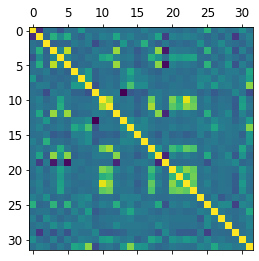

In [271]:
corr_matrix = org_train_dataset.corr()
plt.matshow(corr_matrix)
plt.show()

In [272]:
#corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)
# Fill diagonal and upper half with NaNs
corr_matrix_temp = corr_matrix.copy()
mask = np.zeros_like(corr_matrix_temp, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr_matrix_temp[mask] = np.nan
corr_matrix_temp.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1).highlight_null(
    null_color='#f1f1f1').set_precision(2)


C:\Users\saika\AppData\Local\Temp\ipykernel_20900\277405862.py:8: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  null_color='#f1f1f1').set_precision(2)


,key,having_IP,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
key,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
having_IP,-0.38,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
URL_Length,0.00,-0.05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Shortining_Service,-0.00,0.40,-0.10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
having_At_Symbol,-0.18,0.16,-0.07,0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
double_slash_redirecting,0.00,0.39,-0.08,0.84,0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Prefix_Suffix,-0.01,-0.01,0.05,-0.09,-0.01,-0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
having_Sub_Domain,0.23,-0.08,-0.00,-0.03,-0.06,-0.03,0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
SSLfinal_State,-0.02,0.07,0.05,-0.06,0.03,-0.04,0.26,0.27,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Domain_registeration_length,-0.01,-0.02,-0.22,0.06,0.02,0.04,-0.09,-0.09,-0.19,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [273]:
corr_matrix["Result"].sort_values(ascending=False)


Result                         1.000000
SSLfinal_State                 0.712543
URL_of_Anchor                  0.696394
web_traffic                    0.355581
Prefix_Suffix                  0.344660
having_Sub_Domain              0.296728
Request_URL                    0.254572
Links_in_tags                  0.238802
SFH                            0.217931
age_of_domain                  0.135198
Google_Index                   0.121896
Page_Rank                      0.102920
having_IP                      0.094027
DNSRecord                      0.081927
Statistical_report             0.068015
URL_Length                     0.059331
having_At_Symbol               0.050045
on_mouseover                   0.042180
Links_pointing_to_page         0.035003
port                           0.033971
Submitting_to_email            0.011981
RightClick                     0.004880
key                           -0.000854
popUpWidnow                   -0.002868
Favicon                       -0.003260


In [274]:
org_train_dataset_features = org_train_dataset.iloc[:, 1:31].values
org_train_dataset_labels = org_train_dataset.iloc[:, 31].values

X_train, X_test, y_train, y_test = train_test_split(
    org_train_dataset_features, org_train_dataset_labels, test_size=0.10, random_state=42)


In [275]:
skfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.9233345738742091
0.9218168279970216
0.9154877140729709
